In [3]:
# set up tic tac toe environment

import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
env = TictactoeEnv()

In [2]:
# build the DQN model

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple


Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):

        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Policy(nn.Module):

    def __init__(self, n_inputs=3 * 3 * 2, n_outputs=9):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def act(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].view(1, 1)
        
def grid2list(grid, player):
    grid = grid.reshape(-1)
    a = []
    b = []
    for i in range(len(grid)):
        if grid[i] == 1:
            if player == 1:
                a.append(1)
                b.append(0)
            else:
                a.append(0)
                b.append(1)
        elif grid[i] == -1:
            if player == 1:
                a.append(0)
                b.append(1)
            else:
                a.append(1)
                b.append(0)
        else:
            a.append(0)
            b.append(0)
    return np.concatenate((a, b))

def compute_mopt(target):
    num_win = 0
    num_loss = 0
    
    Turns = np.array(['X','O'])
    for game in range(500):
        env.reset()
        
        opt_turn = Turns[game%2]
        agent_turn = Turns[(game+1)%2]
    
        player_opt = OptimalPlayer(epsilon = 0, player = opt_turn)
        
        grid, _, __ = env.observe()
       
        for j in range(9):
            
            if env.current_player == player_opt.player:
                action = player_opt.act(grid)
                grid, done, winner = env.step(action)
            else:  
                
                if agent_turn == 'X':
                    player = 1
                else:
                    player = 2
                
                state = torch.tensor([grid2list(grid, player)], dtype=torch.float)
                action = target.act(state)
                action = action.item()

                if state[0][action] == 1 or state[0][action+9] == 1:
                    num_loss += 1
                    env.reset()
                    break
                
                grid, done, winner = env.step(action)
                

            if done:
                if winner == opt_turn:
                    num_loss += 1
                elif winner == agent_turn:
                    num_win += 1
                #env.render()
                env.reset()
                break
    return (num_win - num_loss) / 500

def compute_mrand(target):
    num_win = 0
    num_loss = 0
    
    Turns = np.array(['X','O'])
    for game in range(500):
        env.reset()
        
        opt_turn = Turns[game%2]
        agent_turn = Turns[(game+1)%2]
    
        player_opt = OptimalPlayer(epsilon = 1, player = opt_turn)
        
        grid, _, __ = env.observe()
       
        for j in range(9):
            
            if env.current_player == player_opt.player:
                action = player_opt.act(grid)
                grid, done, winner = env.step(action)
            else:  
                
                if agent_turn == 'X':
                    player = 1
                else:
                    player = 2
                
                state = torch.tensor([grid2list(grid, player)], dtype=torch.float)
                action = target.act(state)
                action = action.item()

                if state[0][action] == 1 or state[0][action+9] == 1:
                    num_loss += 1
                    env.reset()
                    break
                
                grid, done, winner = env.step(action)
                

            if done:
                if winner == opt_turn:
                    num_loss += 1
                elif winner == agent_turn:
                    num_win += 1
                #env.render()
                env.reset()
                break
    return (num_win - num_loss) / 500


def compute_reward_and_loss(reward, loss):

    a = 0
    b = 0
    c = 0

    reward_250 = []
    loss_250 = []

    for i in range(len(reward)):
        if loss[i] is not None:
            b += loss[i].item()
        else:
            c += 1
        a += reward[i]

        if i % 249 == 0 and i != 0:
            reward_250.append(a/250)
            a = 0
            loss_250.append(b/(250-c))
            b = 0
            c = 0
    
    return reward_250, loss_250

In [4]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Tuple
import random
import logging
import io
from tqdm import tqdm

def fit(
    n_games: int = 20000,
    batch_size: int = 64,
    gamma: float = 0.99,
    eps_start: float = 0.8,
    eps_end: float = 0.1,
    eps_steps: int = 10000,
    eps: float = 0.2,
    adaptive_eps = False,
    n = 20000,
    memory_size = 10000,
    compute_mopts = True,
    opt_eps = 0.5
) -> bytes:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logging.info("Beginning training on: {}".format(device))

    target_update = 250
    policy = Policy(n_inputs=18, n_outputs=9).to(device)
    target = Policy(n_inputs=18, n_outputs=9).to(device)
    target.load_state_dict(policy.state_dict())
    target.eval()

    optimizer = optim.Adam(policy.parameters(), lr=5e-4)
    memory = ReplayMemory(memory_size)

    env = TictactoeEnv()

    Turns = np.array(['X','O'])
    
    player = 0
    
    game_reward = []
    
    game_loss = []
    
    mopts = []
    
    mrands = []
    
    for game in tqdm(range(n_games)):
        
        if adaptive_eps == False:
            eps = eps
        else:
            eps = max(eps_end, eps_start*(1-game/n))
        
        env.reset()
        grid = env.observe()[0]
        state = torch.tensor([grid2list(grid, 1)], dtype=torch.float).to(device)
        
        player = player % 2 + 1
        turn = Turns[2-player]
        opt_player = OptimalPlayer(epsilon=opt_eps, player=turn)
        
        for j in range(9):         
            
            is_valid = True
            if env.current_player == opt_player.player:
                action = opt_player.act(grid)
                grid, done, winner = env.step(action)
                continue
            
            state = torch.tensor([grid2list(grid, player)], dtype=torch.float).to(device)
            action, was_random = select_model_action(device, policy, state, eps)
            _action = action
            action = action.item()

            if state[0][action] == 1 or state[0][action+9] == 1:
                reward = -1
                is_valid = False
                '''
                #game_reward.append(reward)
                memory.push(state, _action, next_state, torch.tensor([reward], device=device))
                #print(_action)
                action, was_random = select_model_action(device, policy, state, eps)
                _action = action
                action = action.item()
                '''
            else:
                tmp_grid, done, winner = env.step(action)
                reward = env.reward(player=Turns[player-1])
              
            '''
            # print(action)
            next_grid, done, winner = env.step(action)
            next_state = torch.tensor([grid2list(next_grid, player)], dtype=torch.float).to(device)
            '''
            #game_reward.append(reward)
            
            if done or (not is_valid):
                next_state = None
                if memory_size != 0:
                    memory.push(state, _action, next_state, torch.tensor([reward], device=device))
                optimize_model(
                    device=device,
                    optimizer=optimizer,
                    policy=policy,
                    target=target,
                    memory=memory,
                    batch_size=batch_size,
                    gamma=gamma,
                )
                #game_loss.append(loss)
                break
                
            opt_move = opt_player.act(tmp_grid)
            next_grid, done, winner = env.step(opt_move)
            reward = env.reward(player=Turns[player-1])
            # Observe new state
            if not done:
                next_state = torch.tensor([grid2list(next_grid, player)], dtype=torch.float).to(device)
            else:
                next_state = None

            # Store the transition in memory
            if memory_size != 0:
                memory.push(state, _action, next_state, torch.tensor([reward], device=device))
            #game_reward.append(reward)
            # Perform one step of the optimization (on the policy network)
            optimize_model(
                device=device,
                optimizer=optimizer,
                policy=policy,
                target=target,
                memory=memory,
                batch_size=batch_size,
                gamma=gamma,
            )
            #game_loss.append(loss)
            # Move to the next state
            grid = next_grid

            if done:
                break
            '''
            if done:
                if winner is None:
                    reward = 0
                elif winner == turn:
                    reward = -1
                else:
                    reward = 1
                
                game_reward.append(reward)
                if env.current_player != opt_player.player:
                    memory.push(state, _action, next_state, torch.tensor([reward], device=device))
                # env.render()
                break
            else:
                reward = 0
                if env.current_player != opt_player.player:
                    memory.push(state, _action, next_state, torch.tensor([reward], device=device))
                state = next_state
                grid = next_grid
            '''
    
        loss = optimize_model(
            device=device,
            optimizer=optimizer,
            policy=policy,
            target=target,
            memory=memory,
            batch_size=batch_size,
            gamma=gamma,
        )
        game_loss.append(loss)
        game_reward.append(reward)
        if game % target_update == 0:
            target.load_state_dict(policy.state_dict())
            if compute_mopts == True:
                mopt = compute_mopt(policy)
                mopts.append(mopt)
                mrand = compute_mrand(policy)
                mrands.append(mrand)
        
        

    logging.info("Complete")

    res = io.BytesIO()
    torch.save(policy.state_dict(), res)

    return res.getbuffer(), game_reward, game_loss, mopts, mrands


def optimize_model(
    device: torch.device,
    optimizer: optim.Optimizer,
    policy: Policy,
    target: Policy,
    memory: ReplayMemory,
    batch_size: int,
    gamma: float,
):
    """Model optimization step, copied verbatim from the Torch DQN tutorial.
    
    Arguments:
        device {torch.device} -- Device
        optimizer {torch.optim.Optimizer} -- Optimizer
        policy {Policy} -- Policy module
        target {Policy} -- Target module
        memory {ReplayMemory} -- Replay memory
        batch_size {int} -- Number of observations to use per batch step
        gamma {float} -- Reward discount factor
    """
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    try:
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])  
    except:
        non_final_next_states = None
        
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    if non_final_next_states is not None:
        next_state_values[non_final_mask] = target(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    
    # Compute Huber loss
    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1)
    )

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return(loss)
    '''
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.detach()
    '''



def select_model_action(
    device: torch.device, model: Policy, state: torch.tensor, eps: float
) -> Tuple[torch.tensor, bool]:
    """Selects an action for the model: either using the policy, or
    by choosing a random valid action (as controlled by `eps`)
    
    Arguments:
        device {torch.device} -- Device
        model {Policy} -- Policy module
        state {torch.tensor} -- Current board state, as a torch tensor
        eps {float} -- Probability of choosing a random state.
    
    Returns:
        Tuple[torch.tensor, bool] -- The action, and a bool indicating whether
                                     the action is random or not.
    """

    sample = random.random()
    if sample > eps:
        return model.act(state), False
    else:
        return (
            torch.tensor(
                [[random.randrange(0, 9)]],
                device=device,
                dtype=torch.long,
            ),
            True,
        )

In [6]:
def compute_reward_and_loss(reward, loss):

    a = 0
    b = 0
    c = 0

    reward_250 = []
    loss_250 = []

    for i in range(len(reward)):
        if loss[i] is not None:
            b += loss[i].item()
        else:
            c += 1
        a += reward[i]

        if i % 249 == 0 and i != 0:
            reward_250.append(a/250)
            a = 0
            loss_250.append(b/(250-c))
            b = 0
            c = 0
    
    return reward_250, loss_250

In [136]:
_, reward_11, loss_11, mopts_11, mrands_11 = fit(eps = 0.2, compute_mopts = False)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:33<00:00, 38.99it/s]


In [7]:
reward_250_11, loss_250_11 = compute_reward_and_loss(reward_11, loss_11)


import matplotlib.pyplot as plt
plt.plot(reward_250_11)
plt.ylabel('reward')
plt.show()
plt.plot(loss_250_11)
plt.ylabel('loss')
plt.show()

NameError: name 'reward_11' is not defined

In [131]:
_, reward, loss, mopts, mrands = fit(batch_size = 1, memory_size = 1)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [15:51<00:00, 21.01it/s]


In [132]:
reward_250, loss_250 = compute_reward_and_loss(reward, loss) 

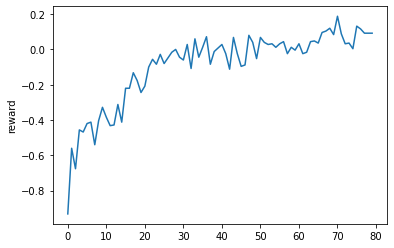

In [133]:
import matplotlib.pyplot as plt
plt.plot(reward_250)
plt.ylabel('reward')
plt.show()

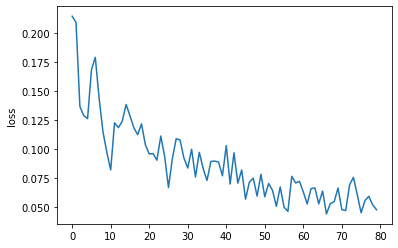

In [134]:
plt.plot(loss_250)
plt.ylabel('loss')
plt.show()

In [125]:
_, reward_12, loss_12, mopts_12, mrands_12 = fit(
    adaptive_eps = True,
    n = 20000,
)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:01:10<00:00,  5.45it/s]


In [126]:
reward_250_12, loss_250_12 = compute_reward_and_loss(reward_12, loss_12)


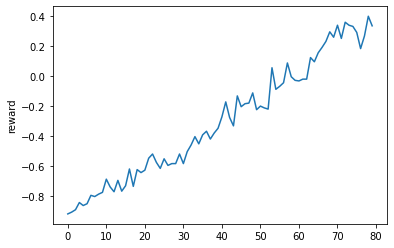

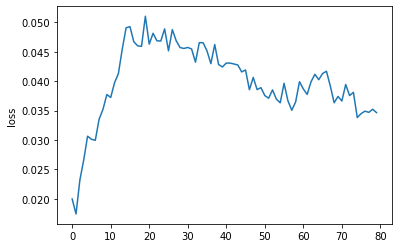

In [127]:
plt.plot(reward_250_12)
plt.ylabel('reward')
plt.show()
plt.plot(loss_250_12)
plt.ylabel('loss')
plt.show()

In [96]:
len(targets_12)

80

In [112]:
def compute_mopt(target):
    num_win = 0
    num_loss = 0
    
    Turns = np.array(['X','O'])
    for game in range(500):
        env.reset()
        
        opt_turn = Turns[game%2]
        agent_turn = Turns[(game+1)%2]
    
        player_opt = OptimalPlayer(epsilon = 0, player = opt_turn)
        
        grid, _, __ = env.observe()
       
        for j in range(9):
            
            if env.current_player == player_opt.player:
                action = player_opt.act(grid)
                grid, done, winner = env.step(action)
            else:  
                
                if agent_turn == 'X':
                    player = 1
                else:
                    player = 2
                
                state = torch.tensor([grid2list(grid, player)], dtype=torch.float)
                action = target.act(state)
                action = action.item()

                if state[0][action] == 1 or state[0][action+9] == 1:
                    num_loss += 1
                    env.reset()
                    break
                
                grid, done, winner = env.step(action)
                

            if done:
                if winner == opt_turn:
                    num_loss += 1
                elif winner == agent_turn:
                    num_win += 1
                #env.render()
                env.reset()
                break
    return (num_win - num_loss) / 500

def compute_mrand(target):
    num_win = 0
    num_loss = 0
    
    Turns = np.array(['X','O'])
    for game in range(500):
        env.reset()
        
        opt_turn = Turns[game%2]
        agent_turn = Turns[(game+1)%2]
    
        player_opt = OptimalPlayer(epsilon = 1, player = opt_turn)
        
        grid, _, __ = env.observe()
       
        for j in range(9):
            
            if env.current_player == player_opt.player:
                action = player_opt.act(grid)
                grid, done, winner = env.step(action)
            else:  
                
                if agent_turn == 'X':
                    player = 1
                else:
                    player = 2
                
                state = torch.tensor([grid2list(grid, player)], dtype=torch.float)
                action = target.act(state)
                action = action.item()

                if state[0][action] == 1 or state[0][action+9] == 1:
                    num_loss += 1
                    env.reset()
                    break
                
                grid, done, winner = env.step(action)
                

            if done:
                if winner == opt_turn:
                    num_loss += 1
                elif winner == agent_turn:
                    num_win += 1
                #env.render()
                env.reset()
                break
    return (num_win - num_loss) / 500

In [110]:
mopts = []
for target in tqdm(targets_12):
    mopt = compute_mopt(target)
    mopts.append(mopt)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [04:55<00:00,  3.69s/it]


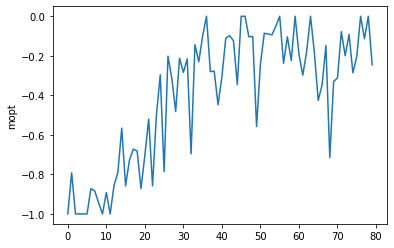

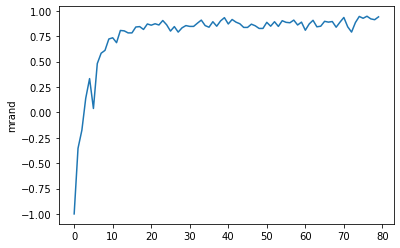

In [128]:
plt.plot(mopts_12)
plt.ylabel('mopt')
plt.show()
plt.plot(mrands_12)
plt.ylabel('mrand')
plt.show()